In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Improved Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word not in stop_words]
    return ' '.join(words).strip()

# Load dataset
df = pd.read_csv("sentimentdataset.csv")
df = df[["Text", "Sentiment"]]
df["Sentiment"] = df["Sentiment"].str.strip()
df["ProcessedText"] = df["Text"].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
df["SentimentEncoded"] = label_encoder.fit_transform(df["Sentiment"])

# Remove rare classes
class_counts = df["SentimentEncoded"].value_counts()
rare_classes = class_counts[class_counts < 2].index
df = df[~df["SentimentEncoded"].isin(rare_classes)]

# Split dataset
X = df["ProcessedText"]
y = df["SentimentEncoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=30000, min_df=3, stop_words="english", sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts())

# Ensure SMOTE doesn't fail due to small class sizes
min_class_size = y_train.value_counts().min()
k_neighbors = min(5, min_class_size - 1)  # Ensures k < class size

# Apply SMOTE with reduced k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_train).value_counts())

# # Define parameter grid for MLP (Added more layers & optimizers)
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # More architectures
#     'activation': ['relu', 'tanh'],  # Activation functions
#     'solver': ['adam', 'sgd'],  # Added SGD optimizer
#     'alpha': [0.0001, 0.001],  # L2 regularization
#     'learning_rate': ['constant', 'adaptive'],  # Learning rate strategy
#     'batch_size': [32],  # Mini-batch training
#     'max_iter': [500]  # Increased training iterations
# }

# # Perform Grid Search with Cross Validation
# mlp = MLPClassifier(random_state=42)
# grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
# grid_search.fit(X_train_tfidf, y_train)

# Best model

best_mlp = MLPClassifier(
    activation='relu',
    alpha=0.001,
    batch_size=32,
    hidden_layer_sizes=(100, 100),
    learning_rate='constant',
    max_iter=500,
    solver='adam',
    random_state=42
)
best_mlp.fit(X_train_tfidf, y_train)

# Predict with the best model
y_pred = best_mlp.predict(X_test_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define DNN model
def build_dnn_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare DNN input data
num_classes = len(label_encoder.classes_)
y_train_dnn = to_categorical(y_train, num_classes=num_classes)
y_test_dnn = to_categorical(y_test, num_classes=num_classes)

# Build and train the DNN
input_dim = X_train_tfidf.shape[1]
dnn_model = build_dnn_model(input_dim, num_classes)
dnn_model.fit(X_train_tfidf.toarray(), y_train_dnn, epochs=10, batch_size=32, validation_split=0.1)

# Predictions
y_pred_dnn = np.argmax(dnn_model.predict(X_test_tfidf.toarray()), axis=1)
print("DNN Accuracy:", accuracy_score(y_test, y_pred_dnn))
print("DNN Classification Report:\n", classification_report(y_test, y_pred_dnn))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Class distribution before SMOTE:
 SentimentEncoded
146    36
116    35
76     29
40     15
135    14
       ..
70      2
53      2
157     2
20      2
43      2
Name: count, Length: 112, dtype: int64
Class distribution after SMOTE:
 SentimentEncoded
136    36
41     36
93     36
184    36
24     36
       ..
70     36
53     36
157    36
20     36
43     36
Name: count, Length: 112, dtype: int64
Best Accuracy: 0.6107
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          17  

c:\Users\krish\OneDrive-MSFT\Subjects6thSemester\NLP\Assignments\NLP_IIITB\assign-1_NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\krish\OneDrive-MSFT\Subjects6thSemester\NLP\Assignments\NLP_IIITB\assign-1_NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\krish\OneDrive-MSFT\Subjects6thSemester\NLP\Assignments\NLP_IIITB\assign-1_NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0322 - loss: 4.9281 - val_accuracy: 0.0000e+00 - val_loss: 9.4814
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6673 - loss: 1.6427 - val_accuracy: 0.0693 - val_loss: 9.0895
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9134 - loss: 0.4386 - val_accuracy: 0.0842 - val_loss: 5.9736
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9488 - loss: 0.2418 - val_accuracy: 0.1881 - val_loss: 3.5447
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9578 - loss: 0.1668 - val_accuracy: 0.5866 - val_loss: 1.7192
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9664 - loss: 0.1288 - val_accuracy: 0.8713 - val_loss: 0.9971
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9766 - loss: 0.0902 - val_accuracy: 0.8936 - val_loss: 0.7355
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9854 - loss: 0.0614 - val_accuracy: 0.9406 -

c:\Users\krish\OneDrive-MSFT\Subjects6thSemester\NLP\Assignments\NLP_IIITB\assign-1_NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\krish\OneDrive-MSFT\Subjects6thSemester\NLP\Assignments\NLP_IIITB\assign-1_NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\krish\OneDrive-MSFT\Subjects6thSemester\NLP\Assignments\NLP_IIITB\assign-1_NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

## Overall Accuracy, Macro F1, Weighted F1
Visualizes general model performance with single score metrics.

In [2]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

Accuracy: 0.6107
Macro F1-score: 0.5357
Weighted F1-score: 0.5780


Because the test data is less, and classes are more. Prediction is only able to predict 88 out of the 191 labels. So we are not creating matrix for the 10 most frequent labels

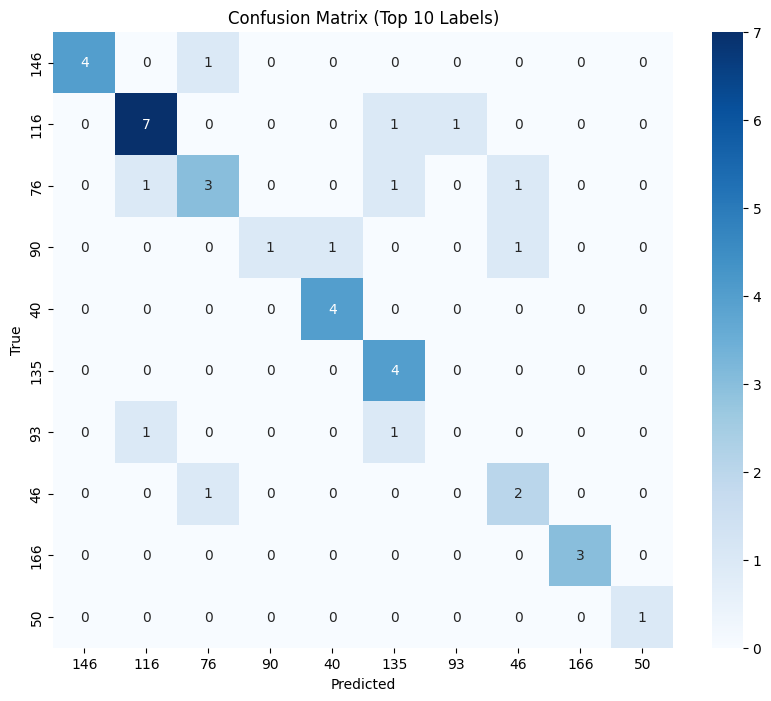

In [5]:
# 2. Top N Frequent Labels – Confusion Matrix Subset
# Plot confusion matrix for top N most frequent classes only.
import numpy as np
import seaborn as sns

# Get top N labels by frequency in test set
from collections import Counter

N = 10  # Number of top labels to visualize
label_counts = Counter(y_test)
top_labels = [label for label, _ in label_counts.most_common(N)]

# Filter predictions and true labels for top N
mask = np.isin(y_test, top_labels)
filtered_y_test = y_test[mask]
filtered_y_pred = y_pred[mask]

# Confusion Matrix for top N labels
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=top_labels,
    yticklabels=top_labels,
    cmap="Blues",
)
plt.title(f"Confusion Matrix (Top {N} Labels)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()